In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from collections import Counter
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# Utils

In [2]:
def plot_decision_boundary_2d(X, model):
  h = .02  # step size in the mesh
  # create a mesh to plot in
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))

  # Plot the decision boundary. For that, we will assign a color to each
  # point in the mesh [x_min, m_max]x[y_min, y_max].
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

# Bagging model class

In [3]:
class BaggingBase():
  def __init__(self, model_factory_fun, n_models, sample_size=None):
    self.model_factory_fun = model_factory_fun
    self.n_models = n_models
    self.sample_size = sample_size
  
  def fit(self, X, Y):
    N = len(Y)
    b_sample_size = self.sample_size if self.sample_size is not None else N
    self.models = []
    for k in range(self.n_models):
      sample_idx = np.random.choice(N, size=b_sample_size, replace=True)
      Xb = X[sample_idx]
      Yb = Y[sample_idx]

      model = self.model_factory_fun()
      model.fit(Xb, Yb)
      self.models.append(model)
  
  def _predictions(self, X):
    predictions = []
    for model in self.models:
      pred = model.predict(X)
      predictions.append(pred)
    return np.array(predictions)


class BaggingRegressor(BaggingBase):
  def __init__(self, model_factory_fun, n_models, sample_size=None):
    super().__init__(model_factory_fun, n_models, sample_size)
  
  def predict(self, X):
    predictions = super()._predictions(X)
    return predictions.mean(axis=0)

  def score(self, X, Y):
    Y_hat = self.predict(X)
    return r2_score(Y_hat, Y)
    

class BaggingClassifier(BaggingBase):
  def __init__(self, model_factory_fun, n_models, sample_size=None):
    super().__init__(model_factory_fun, n_models, sample_size)
   
  def predict(self, X):
    predictions = super()._predictions(X)
    if (len(predictions[0].shape) > 1):
      raise Exception(f'Only non sparse prediction output is supported. Shape of single model prediction is:{predictions[0].shape}')
    else:
      N = len(X)
      Y_hat = np.zeros(N)
      for i in range(N):
        Y_hat[i] = self._most_frequent(predictions[:, i])
      return Y_hat

  def score(self, X, Y):
    Y_hat = self.predict(X)
    return (Y_hat == Y).mean()
  
  def _most_frequent(self, array1d):
    occurence_count = Counter(array1d)
    return occurence_count.most_common(1)[0][0]


# Use BaggingRegressor in np.sin + noise

In [4]:
T = 100
x_axis = np.linspace(0, 2*np.pi, T)
y_axis = np.sin(x_axis)

N = 30
idx = np.random.choice(T, size=N, replace=False)
Xtrain = x_axis[idx].reshape(N, 1)
Ytrain = y_axis[idx]

## Single (not bagged) model for comparison

In [5]:
model = DecisionTreeRegressor()
model.fit(Xtrain, Ytrain)
simple_prediction = model.predict(x_axis.reshape(T, 1))
simple_score = model.score(x_axis.reshape(T, 1), y_axis)
print('score for 1 tree:', simple_score)

score for 1 tree: 0.9872742474001879


## Bagging model

In [6]:
B = 300
bagging_model = BaggingRegressor(DecisionTreeRegressor, B)
bagging_model.fit(Xtrain, Ytrain)
bagging_prediction = bagging_model.predict(x_axis.reshape(T, 1))
bagging_score = bagging_model.score(x_axis.reshape(T, 1), y_axis)
print(f'bagging model score for {B} tree:{bagging_score}')

bagging model score for 300 tree:0.980712039970666


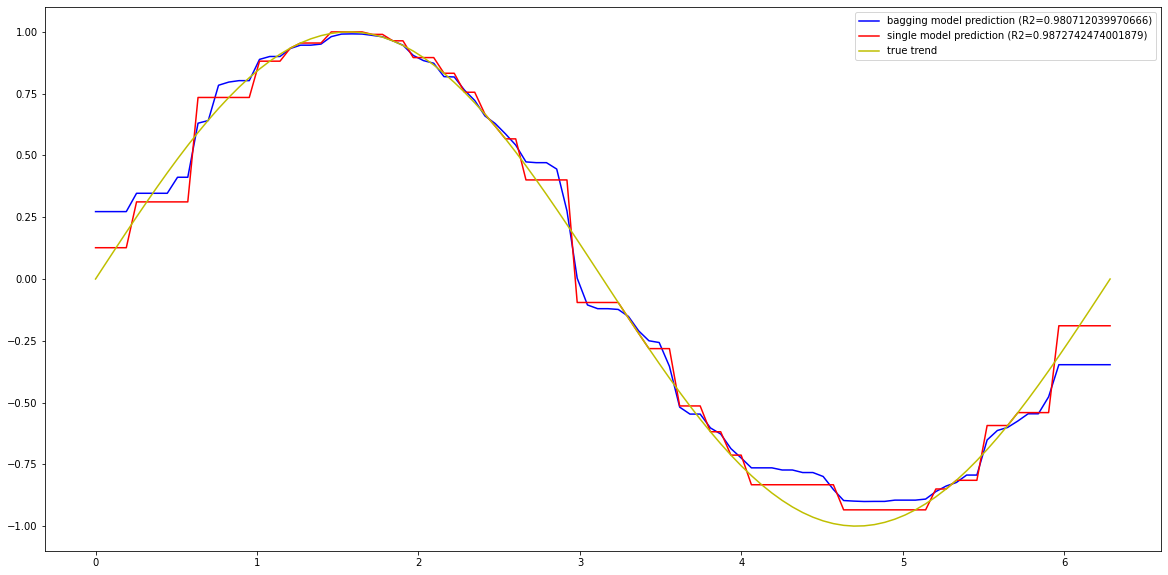

In [7]:
plt.figure(figsize=(20,10))
plt.plot(x_axis, bagging_prediction, color='b', label=f'bagging model prediction (R2={bagging_score})')
plt.plot(x_axis, simple_prediction, color='r', label=f'single model prediction (R2={simple_score})')
plt.plot(x_axis, y_axis, color='y', label='true trend')
plt.legend();

# Use BaggingClassifier

In [8]:
np.random.seed(10)
N = 500
D = 2

def plot_data(X, Y):
  plt.figure(figsize=(10,10))
  plt.scatter(X[:,0], X[:,1], s=100, c=Y, alpha=0.5)
  plt.show()

def get_noisy_xor_data():
  sep = 2
  X = np.random.randn(N, D)
  X[:N//4] += np.array([sep, sep])
  X[N//4:2*N//4] += np.array([sep, -sep])
  X[2*N//4:3*N//4] += np.array([-sep, -sep])
  X[3*N//4:] += np.array([-sep, sep])
  Y = np.array([0]*(N//4) + [1]*(N//4) + [0]*(N//4) + [1]*(N//4))
  #plot_data(X, Y)
  return X, Y

def get_noisy_circles_data():
  sep = 1.5
  X = np.random.randn(N, D)
  X[:N//2] += np.array([sep, sep])
  X[N//2:] += np.array([-sep, -sep])
  Y = np.array([0]*(N//2) + [1]*(N//2))
  #plot_data(X, Y)
  return X, Y

X_circle, Y_circle = get_noisy_circles_data()

## noisy xor in single (not bagged) model for comparison

score for 1 tree: 1.0


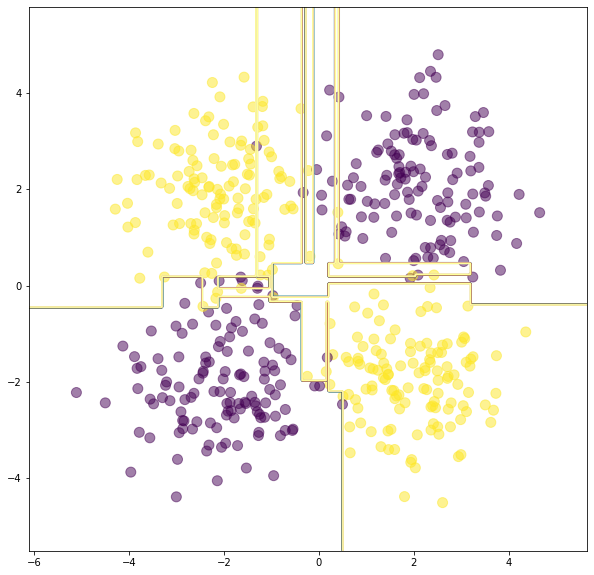

In [9]:
X, Y = get_noisy_xor_data()

model = DecisionTreeClassifier()
model.fit(X, Y)
print("score for 1 tree:", model.score(X, Y))

plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], s=100, c=Y, alpha=0.5)
plot_decision_boundary_2d(X, model)
plt.show()

## noisy xor in bagging model

score for bagged model: 0.668


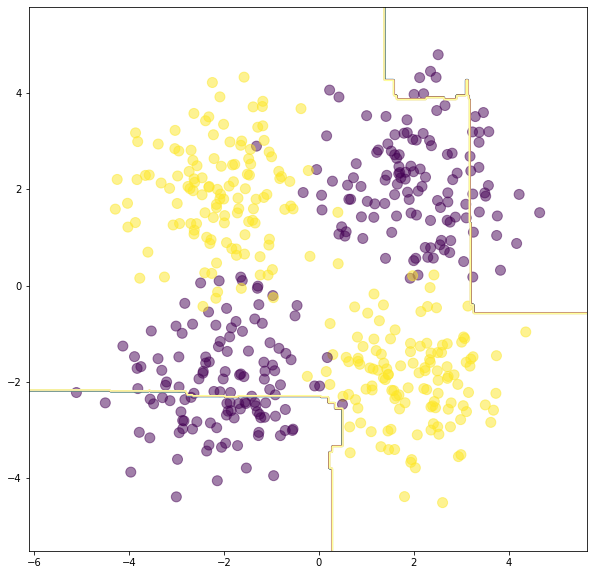

In [10]:
model = BaggingClassifier(lambda : DecisionTreeClassifier(max_depth=2), 200)
model.fit(X, Y)

print("score for bagged model:", model.score(X, Y))

plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], s=100, c=Y, alpha=0.5)
plot_decision_boundary_2d(X, model)
plt.show()